In [1]:
from tensorflow import keras
from keras import layers, activations, utils, optimizers, losses, metrics, callbacks

2023-09-13 19:37:20.739320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 19:37:20.864908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 19:37:20.865696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 19:37:21.491751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2023-09-13 19:37:27.204260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 19:37:27.204546: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


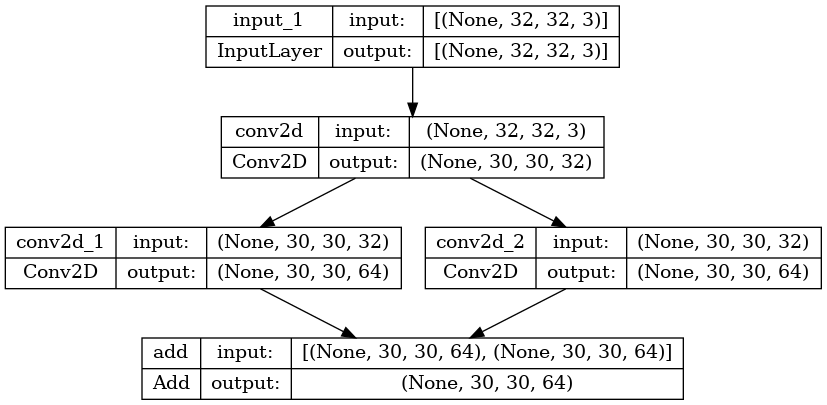

In [2]:
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation=activations.relu)(inputs)
residual = x

x = layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu, padding='same')(x)
residual = layers.Conv2D(filters=64, kernel_size=1)(residual)
x = layers.add([x, residual])

model = keras.Model(inputs=inputs, outputs=x)
utils.plot_model(model, show_shapes=True)

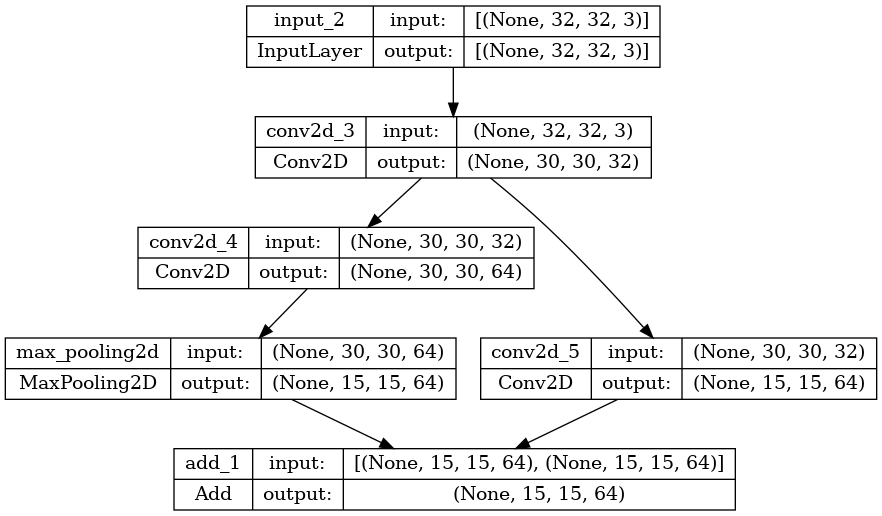

In [3]:
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation=activations.relu)(inputs)
residual = x

x = layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu, padding='same')(x)
x = layers.MaxPool2D(pool_size=2, padding='same')(x)
residual = layers.Conv2D(filters=64, kernel_size=1, strides=2, padding='same')(residual)
x = layers.add([x, residual])

model = keras.Model(inputs=inputs, outputs=x)
utils.plot_model(model, show_shapes=True)

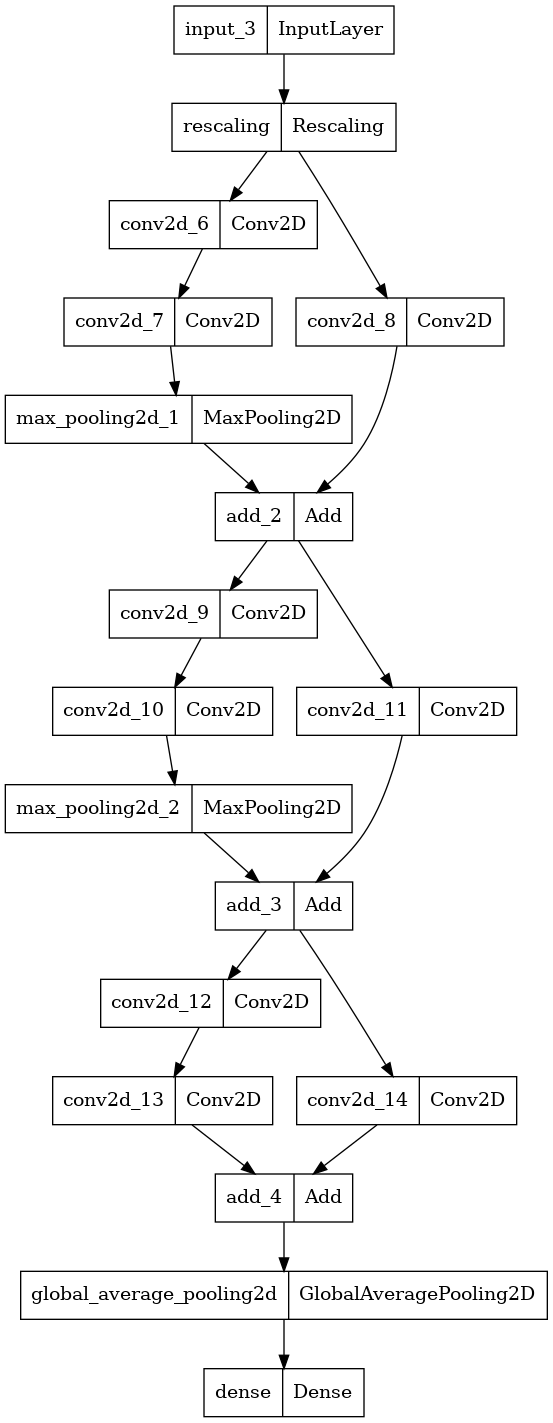

In [4]:
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters=filters, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=filters, kernel_size=3, activation=activations.relu, padding='same')(x)

    if pooling:
        x = layers.MaxPool2D(pool_size=2, padding='same')(x)
        residual = layers.Conv2D(filters=filters, kernel_size=1, strides=2, padding='same')(residual)
    else:
        residual = layers.Conv2D(filters=filters, kernel_size=1)(residual)
    
    x = layers.add([x, residual])
    return x

inputs = layers.Input(shape=(32, 32, 3))
x = layers.Rescaling(1 / 255)(inputs)
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation=activations.sigmoid)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
utils.plot_model(model)

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = layers.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1 / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for depth in [32, 64, 128, 256, 512]:
    residual = x

    for i in range(2):
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activations.relu)(x)
        x = layers.SeparableConv2D(filters=depth, kernel_size=3, padding='same', use_bias=False)(x)
    
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    residual = layers.Conv2D(filters=depth, kernel_size=1, strides=2, padding='same', use_bias=False)(residual)

    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation=activations.sigmoid)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary(show_trainable=True)

Model: "model_3"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_4 (InputLayer)        [(None, 180, 180, 3)]        0         []                            Y          
                                                                                                             
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_4[0][0]']             Y          
                                                                                                             
 rescaling_1 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[0][0]']          Y          
                                                                                                             
 conv2d_15 (Conv2D)          (None, 176, 176, 32)         2400      ['rescaling_1[0][0]']         Y    

 activation_5 (Activation)   (None, 44, 44, 128)          0         ['batch_normalization_5[0][   Y          
                                                                    0]']                                     
                                                                                                             
 separable_conv2d_5 (Separa  (None, 44, 44, 128)          17536     ['activation_5[0][0]']        Y          
 bleConv2D)                                                                                                  
                                                                                                             
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 128)          0         ['separable_conv2d_5[0][0]'   Y          
 g2D)                                                               ]                                        
                                                                                                             
 conv2d_18

Total params: 721857 (2.75 MB)
Trainable params: 718849 (2.74 MB)
Non-trainable params: 3008 (11.75 KB)
_____________________________________________________________________________________________________________


In [6]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_5[0][0]']             
                                                                                                  
 rescaling_2 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[1][0]']          
                                                                                                  
 conv2d_21 (Conv2D)          (None, 176, 176, 32)         2400      ['rescaling_2[0][0]']         
                                                                                            

                                                                                                  
 conv2d_24 (Conv2D)          (None, 22, 22, 128)          8192      ['add_11[0][0]']              
                                                                                                  
 add_12 (Add)                (None, 22, 22, 128)          0         ['max_pooling2d_10[0][0]',    
                                                                     'conv2d_24[0][0]']           
                                                                                                  
 batch_normalization_16 (Ba  (None, 22, 22, 128)          512       ['add_12[0][0]']              
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 22, 22, 128)          0         ['batch_normalization_16[0][0]
          

In [7]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [8]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy()])

callback_list = [
    callbacks.ModelCheckpoint('mini_xception', save_best_only='True')
]

history = model.fit(train_dataset, epochs=100, callbacks=callback_list, validation_data=validation_dataset)

Epoch 1/100


2023-09-13 18:32:13.184457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-13 18:32:13.773468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-13 18:32:13.774176: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5b73c49030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-13 18:32:13.774188: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-09-13 18:32:13.776598: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-13 18:32:13.833051: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

63/63 [==============================] - ETA: 0s - loss: 0.7118 - binary_accuracy: 0.5680INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 10s 82ms/step - loss: 0.7118 - binary_accuracy: 0.5680 - val_loss: 0.6942 - val_binary_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.6691 - binary_accuracy: 0.5895INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 64ms/step - loss: 0.6691 - binary_accuracy: 0.5895 - val_loss: 0.6936 - val_binary_accuracy: 0.5000
Epoch 3/100
61/63 [============================>.] - ETA: 0s - loss: 0.6570 - binary_accuracy: 0.6148INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 61ms/step - loss: 0.6569 - binary_accuracy: 0.6165 - val_loss: 0.6921 - val_binary_accuracy: 0.5170
Epoch 4/100
63/63 [==============================] - 2s 29ms/step - loss: 0.6403 - binary_accuracy: 0.6405 - val_loss: 0.7007 - val_binary_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 2s 29ms/step - loss: 0.6267 - binary_accuracy: 0.6455 - val_loss: 0.7557 - val_binary_accuracy: 0.5000
Epoch 6/100
62/63 [============================>.] - ETA: 0s - loss: 0.6125 - binary_accuracy: 0.6613INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 61ms/step - loss: 0.6119 - binary_accuracy: 0.6615 - val_loss: 0.6909 - val_binary_accuracy: 0.5220
Epoch 7/100
63/63 [==============================] - 2s 29ms/step - loss: 0.5936 - binary_accuracy: 0.7050 - val_loss: 0.8622 - val_binary_accuracy: 0.5000
Epoch 8/100
63/63 [==============================] - ETA: 0s - loss: 0.5866 - binary_accuracy: 0.7085INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 63ms/step - loss: 0.5866 - binary_accuracy: 0.7085 - val_loss: 0.6633 - val_binary_accuracy: 0.6090
Epoch 9/100
61/63 [============================>.] - ETA: 0s - loss: 0.5705 - binary_accuracy: 0.7024INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 64ms/step - loss: 0.5710 - binary_accuracy: 0.7030 - val_loss: 0.6453 - val_binary_accuracy: 0.6430
Epoch 10/100
61/63 [============================>.] - ETA: 0s - loss: 0.5660 - binary_accuracy: 0.7167INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.5620 - binary_accuracy: 0.7200 - val_loss: 0.6177 - val_binary_accuracy: 0.6620
Epoch 11/100
61/63 [============================>.] - ETA: 0s - loss: 0.5463 - binary_accuracy: 0.7357INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.5483 - binary_accuracy: 0.7335 - val_loss: 0.6048 - val_binary_accuracy: 0.6650
Epoch 12/100
63/63 [==============================] - ETA: 0s - loss: 0.4987 - binary_accuracy: 0.7620INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 65ms/step - loss: 0.4987 - binary_accuracy: 0.7620 - val_loss: 0.5977 - val_binary_accuracy: 0.7260
Epoch 13/100
63/63 [==============================] - 2s 29ms/step - loss: 0.5048 - binary_accuracy: 0.7555 - val_loss: 1.0070 - val_binary_accuracy: 0.5850
Epoch 14/100
63/63 [==============================] - 2s 29ms/step - loss: 0.4809 - binary_accuracy: 0.7765 - val_loss: 0.7792 - val_binary_accuracy: 0.6580
Epoch 15/100
63/63 [==============================] - ETA: 0s - loss: 0.4749 - binary_accuracy: 0.7775INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.4749 - binary_accuracy: 0.7775 - val_loss: 0.5819 - val_binary_accuracy: 0.6760
Epoch 16/100
63/63 [==============================] - 2s 31ms/step - loss: 0.4652 - binary_accuracy: 0.7745 - val_loss: 1.5990 - val_binary_accuracy: 0.5470
Epoch 17/100
63/63 [==============================] - 2s 31ms/step - loss: 0.4523 - binary_accuracy: 0.7910 - val_loss: 1.3076 - val_binary_accuracy: 0.5360
Epoch 18/100
63/63 [==============================] - 2s 30ms/step - loss: 0.4413 - binary_accuracy: 0.8030 - val_loss: 1.5464 - val_binary_accuracy: 0.5130
Epoch 19/100
61/63 [============================>.] - ETA: 0s - loss: 0.4400 - binary_accuracy: 0.7941INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 65ms/step - loss: 0.4373 - binary_accuracy: 0.7965 - val_loss: 0.5482 - val_binary_accuracy: 0.7390
Epoch 20/100
63/63 [==============================] - 2s 31ms/step - loss: 0.4078 - binary_accuracy: 0.8115 - val_loss: 2.1428 - val_binary_accuracy: 0.5620
Epoch 21/100
63/63 [==============================] - 2s 30ms/step - loss: 0.4349 - binary_accuracy: 0.7935 - val_loss: 1.5103 - val_binary_accuracy: 0.5310
Epoch 22/100
63/63 [==============================] - 2s 30ms/step - loss: 0.4079 - binary_accuracy: 0.8225 - val_loss: 0.7065 - val_binary_accuracy: 0.6610
Epoch 23/100
63/63 [==============================] - 2s 30ms/step - loss: 0.3984 - binary_accuracy: 0.8285 - val_loss: 0.5625 - val_binary_accuracy: 0.6870
Epoch 24/100
63/63 [==============================] - 2s 31ms/step - loss: 0.3860 - binary_accuracy: 0.8295 - val_loss: 1.0166 - val_binary_accuracy: 0.6740
Epoch 25/100
61/63 [============================>.] - ETA: 0s - loss: 0

INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 65ms/step - loss: 0.3762 - binary_accuracy: 0.8340 - val_loss: 0.5450 - val_binary_accuracy: 0.7500
Epoch 26/100
62/63 [============================>.] - ETA: 0s - loss: 0.3705 - binary_accuracy: 0.8402INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 65ms/step - loss: 0.3716 - binary_accuracy: 0.8395 - val_loss: 0.4809 - val_binary_accuracy: 0.7740
Epoch 27/100
63/63 [==============================] - 2s 29ms/step - loss: 0.3612 - binary_accuracy: 0.8370 - val_loss: 0.5463 - val_binary_accuracy: 0.7650
Epoch 28/100
63/63 [==============================] - 2s 29ms/step - loss: 0.3354 - binary_accuracy: 0.8540 - val_loss: 0.6008 - val_binary_accuracy: 0.7630
Epoch 29/100
63/63 [==============================] - ETA: 0s - loss: 0.3307 - binary_accuracy: 0.8535INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 64ms/step - loss: 0.3307 - binary_accuracy: 0.8535 - val_loss: 0.4175 - val_binary_accuracy: 0.8190
Epoch 30/100
63/63 [==============================] - 2s 29ms/step - loss: 0.3349 - binary_accuracy: 0.8505 - val_loss: 0.4723 - val_binary_accuracy: 0.8030
Epoch 31/100
63/63 [==============================] - 2s 31ms/step - loss: 0.3135 - binary_accuracy: 0.8705 - val_loss: 0.9256 - val_binary_accuracy: 0.6990
Epoch 32/100
63/63 [==============================] - 2s 30ms/step - loss: 0.3166 - binary_accuracy: 0.8625 - val_loss: 0.5947 - val_binary_accuracy: 0.7060
Epoch 33/100
63/63 [==============================] - 2s 29ms/step - loss: 0.3132 - binary_accuracy: 0.8660 - val_loss: 0.5278 - val_binary_accuracy: 0.8040
Epoch 34/100
63/63 [==============================] - 2s 29ms/step - loss: 0.3211 - binary_accuracy: 0.8550 - val_loss: 0.8039 - val_binary_accuracy: 0.7220
Epoch 35/100
63/63 [==============================] - 2s 29ms/step - lo

INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.2869 - binary_accuracy: 0.8775 - val_loss: 0.4094 - val_binary_accuracy: 0.8340
Epoch 39/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2856 - binary_accuracy: 0.8795 - val_loss: 0.7184 - val_binary_accuracy: 0.7560
Epoch 40/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2563 - binary_accuracy: 0.8925 - val_loss: 0.4355 - val_binary_accuracy: 0.8190
Epoch 41/100
63/63 [==============================] - ETA: 0s - loss: 0.2788 - binary_accuracy: 0.8800INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.2788 - binary_accuracy: 0.8800 - val_loss: 0.3861 - val_binary_accuracy: 0.8350
Epoch 42/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2629 - binary_accuracy: 0.8885 - val_loss: 0.8877 - val_binary_accuracy: 0.7170
Epoch 43/100
62/63 [============================>.] - ETA: 0s - loss: 0.2524 - binary_accuracy: 0.8911INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 63ms/step - loss: 0.2532 - binary_accuracy: 0.8910 - val_loss: 0.3605 - val_binary_accuracy: 0.8500
Epoch 44/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2534 - binary_accuracy: 0.8925 - val_loss: 0.9535 - val_binary_accuracy: 0.7020
Epoch 45/100
62/63 [============================>.] - ETA: 0s - loss: 0.2496 - binary_accuracy: 0.8881INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.2504 - binary_accuracy: 0.8875 - val_loss: 0.3509 - val_binary_accuracy: 0.8700
Epoch 46/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2495 - binary_accuracy: 0.8950 - val_loss: 0.4205 - val_binary_accuracy: 0.8440
Epoch 47/100
61/63 [============================>.] - ETA: 0s - loss: 0.2447 - binary_accuracy: 0.9037INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.2420 - binary_accuracy: 0.9050 - val_loss: 0.3149 - val_binary_accuracy: 0.8640
Epoch 48/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2363 - binary_accuracy: 0.9010 - val_loss: 0.6492 - val_binary_accuracy: 0.7640
Epoch 49/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2345 - binary_accuracy: 0.9005 - val_loss: 0.5168 - val_binary_accuracy: 0.8100
Epoch 50/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2298 - binary_accuracy: 0.9055 - val_loss: 0.4054 - val_binary_accuracy: 0.8340
Epoch 51/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2220 - binary_accuracy: 0.9040 - val_loss: 0.7451 - val_binary_accuracy: 0.7330
Epoch 52/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2134 - binary_accuracy: 0.9070 - val_loss: 0.6109 - val_binary_accuracy: 0.7430
Epoch 53/100
63/63 [==============================] - 2s 29ms/step - lo

INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 63ms/step - loss: 0.1573 - binary_accuracy: 0.9390 - val_loss: 0.2950 - val_binary_accuracy: 0.8870
Epoch 82/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1193 - binary_accuracy: 0.9525 - val_loss: 0.3604 - val_binary_accuracy: 0.8810
Epoch 83/100
62/63 [============================>.] - ETA: 0s - loss: 0.1494 - binary_accuracy: 0.9430INFO:tensorflow:Assets written to: mini_xception/assets


INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.1485 - binary_accuracy: 0.9435 - val_loss: 0.2820 - val_binary_accuracy: 0.9100
Epoch 84/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1214 - binary_accuracy: 0.9540 - val_loss: 0.3664 - val_binary_accuracy: 0.8850
Epoch 85/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1519 - binary_accuracy: 0.9445 - val_loss: 0.4343 - val_binary_accuracy: 0.8610
Epoch 86/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1243 - binary_accuracy: 0.9555 - val_loss: 0.3225 - val_binary_accuracy: 0.8980
Epoch 87/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1277 - binary_accuracy: 0.9520 - val_loss: 0.2892 - val_binary_accuracy: 0.9030
Epoch 88/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1284 - binary_accuracy: 0.9485 - val_loss: 0.3686 - val_binary_accuracy: 0.8770
Epoch 89/100
63/63 [==============================] - 2s 29ms/step - lo

INFO:tensorflow:Assets written to: mini_xception/assets


63/63 [==============================] - 4s 62ms/step - loss: 0.1330 - binary_accuracy: 0.9465 - val_loss: 0.2668 - val_binary_accuracy: 0.9000
Epoch 92/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1140 - binary_accuracy: 0.9565 - val_loss: 0.4568 - val_binary_accuracy: 0.8390
Epoch 93/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1320 - binary_accuracy: 0.9455 - val_loss: 0.3892 - val_binary_accuracy: 0.8670
Epoch 94/100
63/63 [==============================] - 2s 29ms/step - loss: 0.0954 - binary_accuracy: 0.9650 - val_loss: 0.5473 - val_binary_accuracy: 0.8510
Epoch 95/100
63/63 [==============================] - 2s 28ms/step - loss: 0.1396 - binary_accuracy: 0.9475 - val_loss: 0.5174 - val_binary_accuracy: 0.8440
Epoch 96/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1084 - binary_accuracy: 0.9570 - val_loss: 0.3114 - val_binary_accuracy: 0.8850
Epoch 97/100
63/63 [==============================] - 2s 30ms/step - lo

In [10]:
model = keras.models.load_model('mini_xception')
model.evaluate(test_dataset)

63/63 [==============================] - 1s 10ms/step - loss: 0.2952 - binary_accuracy: 0.8955


[0.2952456474304199, 0.8955000042915344]